In [93]:
%matplotlib ipympl

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [94]:
def show_img(img, cmap=None):
    plt.figure()
    plt.axis('off')
    plt.imshow(img, cmap=cmap)
    plt.show()

C:\Users\evand\OneDrive\Documents\Art\Photography\2025_06_20_GabbySF\jpg_images\DSC02696.JPG


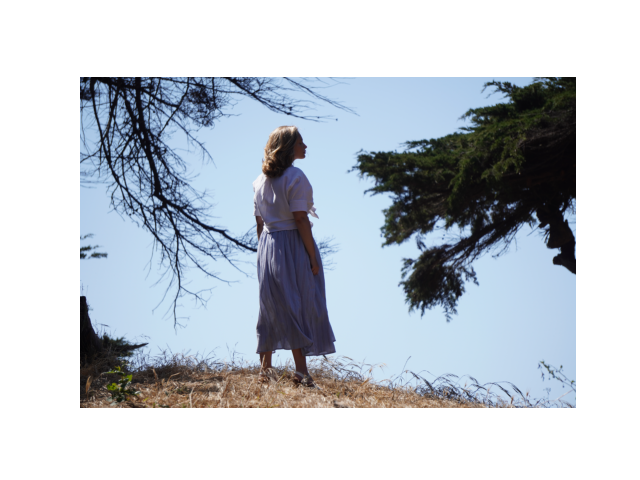

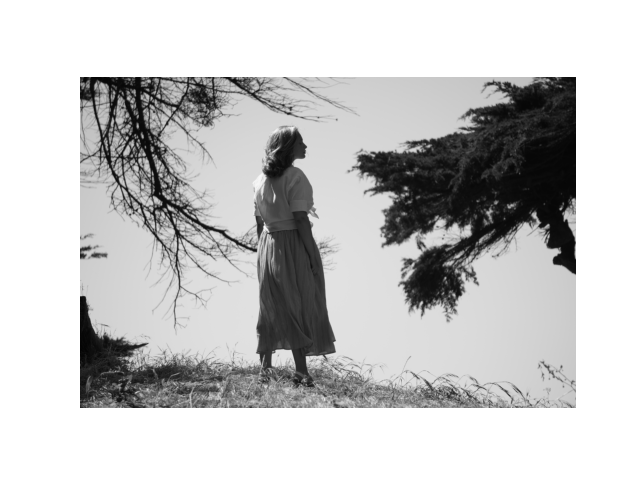

In [95]:
# Load in image with openCV
image_path = r'C:\Users\evand\OneDrive\Documents\Art\Photography\2025_06_20_GabbySF\jpg_images\DSC02696.JPG'
image_path = image_path.replace("\\\\", os.sep)

print(image_path)

img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gry = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

show_img(img_rgb)
show_img(img_gry, cmap='gray')

In [96]:
# Set crucial parameters
layer_height = 0.16 # mm
line_width = 2.5 # mm
max_dim = 256 # mm

min_thickness = layer_height
max_thickness = layer_height * 20

use_border = False # TODO: implement border
border_width = 5.0 # mm
border_height = 3.0 # mm

Resizing image from (4000, 6000) to (68, 102)


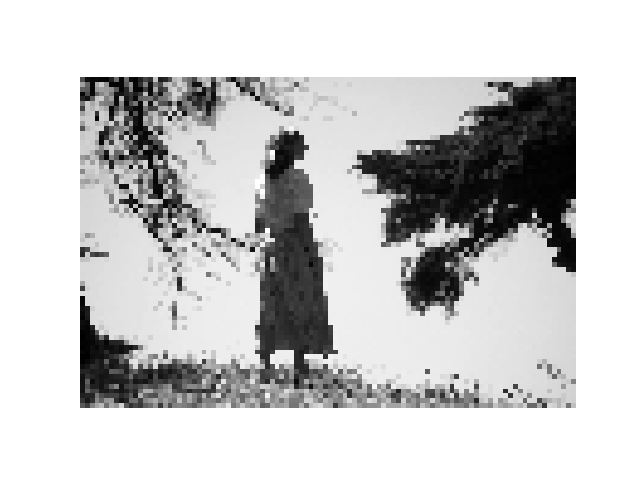

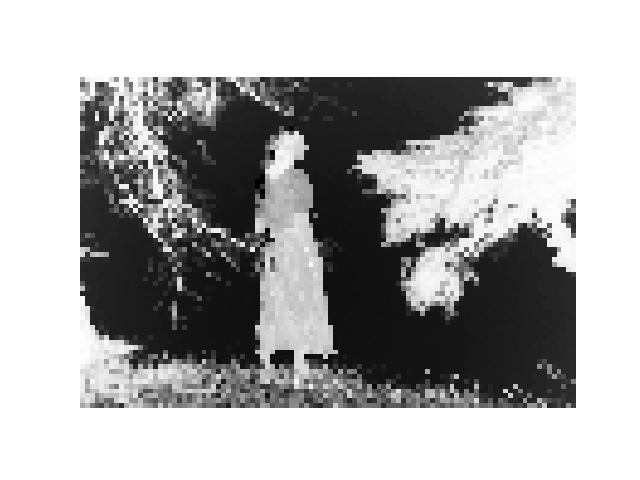

possible range: 0.16mm - 3.2mm
value range: 0.3507450980392157mm - 3.1403921568627453mm


In [97]:
# Transform Image
 
ogH, ogW = img_rgb.shape[:2]

long_res = max_dim // line_width
ratio = max(ogH, ogW) / min(ogH, ogW)
short_res = long_res // ratio

H, W = (int(short_res), int(long_res)) if ogH < ogW else (int(long_res), int(short_res))

# Resize Image
print(f'Resizing image from ({ogH}, {ogW}) to ({H}, {W})')
img_rsz = cv2.resize(img_gry, (W, H), interpolation=cv2.INTER_LINEAR)
show_img(img_rsz, cmap='gray')

# Invert and re-scale image
""" No need to posterize - this will happen for free in slicer?
# Posterize Image
img_pst = np.ceil(img_rsz / (255 / n_values)).astype(np.uint8)
show_img(img_pst, cmap='gray')
"""

img_thk = min_thickness + (1.0 - img_rsz / 255.0) * (max_thickness - min_thickness)
show_img(img_thk, cmap='gray')

print(f'possible range: {min_thickness}mm - {max_thickness}mm')
print(f'value range: {np.min(img_thk)}mm - {np.max(img_thk)}mm')

### STL Format Example

https://top3dshop.com/blog/the-ultimate-guide-to-stl-format

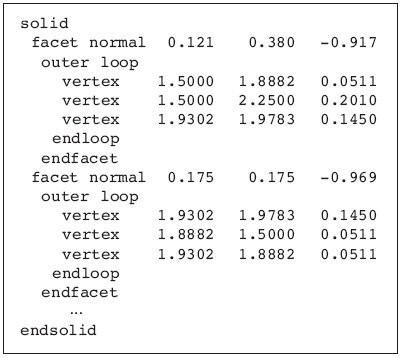

In [98]:
class STL_Tri:
    def __init__(self, v1=None, v2=None, v3=None, normal=None):
        # v1 -> v2 -> v3 must be defined in a counter-clockwise manner such that the right-handed normal vector points outward
        self.v1 = v1
        self.v2 = v2
        self.v3 = v3

        # If normal is set at instantiation, then we won't compute it from vertices
        self.normal = normal
        self.recompute_normal = normal is None

        self.__zero_area = False
        self.compute_normal()

    
    def compute_normal(self):
        if not self.recompute_normal:
            return
        
        if any(x is None for x in [self.v1, self.v2, self.v3]):
            return
        
        normal = np.cross((self.v2-self.v1),(self.v3-self.v2))
        length = np.linalg.norm(normal)

        if length == 0:
            print('Encountered zero-area tri...')
            self.__zero_area = True
            return
        
        self.normal = normal / length

    def compute_area(self):
        return 0.5 * np.linalg.norm(np.abs(np.cross(self.v2 - self.v1, self.v3 - self.v1)))
    
    def zero_area(self):
        return self.__zero_area if self.__zero_area is not None else self.compute_area() == 0.0
    


In [99]:
# Test triangle class
v1, v2, v3 = np.array([0,0,0]), np.array([1,0,0]), np.array([0,1,0])
a = STL_Tri(v1, v2, v3)
print(f'normal:    {a.normal}')
print(f'zero area: {a.zero_area()}')

normal:    [0. 0. 1.]
zero area: False


In [100]:
# Create array of 3D coordinates (in mm) to house image vertex data

"""OLD VERTS METHOD"""
# verts = np.zeros((H,W,3), dtype=np.float32) # 3rd dimension is [x,y,z]

# verts[:,:,0] = np.arange(0,W).reshape((1,W)) * line_width
# verts[:,:,1] = np.arange(0,H).reshape((H,1)) * line_width
# verts[:,:,2] = img_thk

# indices_img = list(zip(X.ravel().astype(np.uint16), Y.ravel().astype(np.uint16)))

X, Y = np.meshgrid(np.arange(0,W), np.arange(0,H))
X = X.ravel() * line_width
Y = Y.ravel() * line_width * (-1)
Y += (H - 1) * line_width

"""NEW VERTS METHOD (2D array)"""
verts = np.zeros((H * W, 3), dtype=np.float32)

verts[:,0] = X
verts[:,1] = Y
verts[:,2] = img_thk.flatten()

In [101]:
# COMPUTE NUMBER OF TRIANGLES TO BE IN MESH
num_tri_img = 2 * (H * W - H - W + 1) # number of triangle in picture mesh
print(f'Image-area triangle count: {num_tri_img}')

# TODO: compute number of tris on each side (using fan optimization)
num_tri_sides = 6 * (H + W) - 8
print(f'Sides triangle count: {num_tri_sides}')

# Compute number of tris on bottom side if using border fan optimization tesselation method
# num_tri_bottom = 2 * (W + H + 1)
# Psych, instead pushing border fan optimization to sides to keep the bottom a 2-tri facet
num_tri_bottom = 2
print(f'Bottom surface triangle count: {num_tri_bottom}')

num_tri = num_tri_img + num_tri_sides + num_tri_bottom
print(f'Total Triangle count: {num_tri}')

# Preallocate Triangle list
tris_img  = [STL_Tri()] * num_tri_img
tris_base = [STL_Tri()] * (num_tri_sides + num_tri_bottom)

Image-area triangle count: 13534
Sides triangle count: 1012
Bottom surface triangle count: 2
Total Triangle count: 14548


In [102]:
### IMAGE MESH
# Assemble Image mesh as squares with triangle subcomponents:
#   v1---v3
#    | / |
#   v2---v4

n_pos_norm = 0
i = 0
for _ in range(int(num_tri_img / 2)):
    
    funky_norm = True

    # When reach end of row, 
    # skip forward because there is no triangle to the right of this pixel
    if (i+1) % W == 0:
        i += 1

    if 2*i >= num_tri_img:
        break

    # Top Triangle of pair
    v1 = verts[i,:]
    v2 = verts[i + W, :]
    v3 = verts[i + 1, :]
    v4 = verts[i + W + 1, :]

    tris_img[2*i]     = STL_Tri(v1, v2, v3)
    tris_img[2*i + 1] = STL_Tri(v3, v2, v4)

    if tris_img[2*i].normal[2] >= 0:        
        n_pos_norm += 1
    
    if tris_img[2*i + 1].normal[2] >= 0:
        n_pos_norm += 1

    i += 1

    

In [103]:
print(f'positive z-norms: {n_pos_norm / num_tri_img * 100:.2f}% ({n_pos_norm} / {num_tri_img}) | ({num_tri_img - n_pos_norm} negative)')

positive z-norms: 99.02% (13402 / 13534) | (132 negative)


In [104]:
### Create the indices for the base verts, starting with the four corners of the bottom of the base
n_verts_base = 2 * (H + W)
verts_base = np.zeros((n_verts_base, 3), dtype=np.float32)

# From top view:
#   1---2
#   | / |
#   3---4
#
# Correct order (since upside-down): 1->2, 2->3

extents = [(H - 1) * line_width, (W - 1) * line_width]

# [X,Y,Z] verts
verts_base[0,:] = [0.0, extents[0], 0.0]        # v1
verts_base[1,:] = [extents[1], extents[0], 0.0] # v2
verts_base[2,:] = [0.0, 0.0, 0.0]               # v3
verts_base[3,:] = [extents[1], 0.0, 0.0]        # v4

tris_base[0] = STL_Tri(verts_base[0,:], verts_base[1,:], verts_base[2,:], normal=[ 0.0,  0.0, -1.0])
tris_base[1] = STL_Tri(verts_base[1,:], verts_base[3,:], verts_base[2,:], normal=[ 0.0,  0.0, -1.0])

In [105]:
Z = min_thickness

# Append with vertices going CW from top view around outer edg,
# starting with top left

X = np.arange(0, W) * line_width
Y = ((H - 1) - np.arange(0, H)) * line_width

# Top side
start = 4
verts_base[start:start+W,0] = X
verts_base[start:start+W,1] = Y[0]
verts_base[start:start+W,2] = Z

# R side
start += W
verts_base[start:start+H-1,0] = X[-1]
verts_base[start:start+H-1,1] = Y[1:]
verts_base[start:start+H-1,2] = Z

# Bottom side
start += H-1
verts_base[start:start+W-1,0] = X[::-1][1:]
verts_base[start:start+W-1,1] = 0.0
verts_base[start:start+W-1,2] = Z

# L side
start += W-1
verts_base[start:start+H-1,0] = 0.0
verts_base[start:start+H-1,1] = Y[::-1][1:-1]
verts_base[start:start+H-1,2] = Z

In [106]:
# Top Side
tri_start_idx = 2
vb_start = 4
for i in range(W-1):
    v1 = verts[i,:]
    v2 = verts[i+1,:]
    v3 = verts_base[vb_start+i,:]
    v4 = verts_base[vb_start+i+1,:]

    # First Tri
    # order = 1->2, 2->3
    tris_base[tri_start_idx + 2*i] = STL_Tri(v1, v2, v3, normal=[0.0, 1.0, 0.0])

    # Second Tri
    # order = 2->4, 4->3
    tris_base[tri_start_idx + 2*i + 1] = STL_Tri(v2, v4, v3, normal=[0.0, 1.0, 0.0])

# Right Side
tri_start_idx += 2 * (W-1)
vb_start += i + 1
for i in range(H-1):
    v1 = verts[i*(W-1),:]
    v2 = verts[i*(W-1)+W,:]
    v3 = verts_base[vb_start+i,:]
    v4 = verts_base[vb_start+i+1,:]

    # First Tri
    # order = 1->2, 2->3
    tris_base[tri_start_idx + 2*i] = STL_Tri(v1, v2, v3, normal=[1.0, 0.0, 0.0])

    # Second Tri
    # order = 2->4, 4->3
    tris_base[tri_start_idx + 2*i + 1] = STL_Tri(v2, v4, v3, normal=[1.0, 0.0, 0.0])


In [107]:
tri_start_idx = 2#int(num_tri_img + 2)
vb_start = 4

match_expected = True
zero_area = False

for side in range(4):
    # Top, Right, Bottom, Left
    # dim = W if side % 2 == 0 else H
    dim = side % 2
    num_edge_pts = H * (dim == 1) + W * (dim == 0)

    for i in range(num_edge_pts - 1):

        step = 1 * (dim == 0) + (W - 1) * (dim == 1)

        v1 = verts[i * step,:]
        v2 = verts[i * step + step + 1,:]
        v3 = verts_base[vb_start + i,:]
        v4 = verts_base[vb_start + i + 1,:]

        nor = np.zeros((3))
        nor[1 - dim] = 1.0 * (side <= 1) - 1.0 * (side > 1)

        # # 1st Tri | order = 1>2>3
        # tris_base[tri_start_idx + 2*i] = STL_Tri(v1, v2, v3, normal=nor)
        # # 2nd Tri | order = 2>4>3
        # tris_base[tri_start_idx + 2*i + 1] = STL_Tri(v2, v4, v3, normal=nor)

        # 1st Tri | order = 1>2>3
        t1 = STL_Tri(v1, v2, v3)
        tris_base[tri_start_idx + 2*i] = t1
        # print(f'side: {side} | nor: {tris_base[tri_start_idx + 2*i].normal}')
        # 2nd Tri | order = 2>4>3
        t2 = STL_Tri(v2, v4, v3)
        tris_base[tri_start_idx + 2*i + 1] = t2
        # print(f'side: {side} | nor: {tris_base[tri_start_idx + 2*i + 1].normal}')

        if not all(t1.normal == nor):
            match_expected = False
            if t1.zero_area():
                zero_area = True
            print(side, nor, t1.normal, f'zero area: {t1.zero_area()}')

        if not all(t2.normal == nor):
            match_expected = False
            if t2.zero_area():
                zero_area = True
            print(side, nor, t2.normal, f'zero area: {t2.zero_area()}')    
            
    print(match_expected)
    print(zero_area)
    

0 [0. 1. 0.] [ 0.0099995 -0.99995    0.       ] zero area: False
0 [0. 1. 0.] [0.         0.43740284 0.89926565] zero area: False
False
False
1 [1. 0. 0.] [0.         0.43740284 0.89926565] zero area: False
1 [1. 0. 0.] [ 0.01159662  0.08079611 -0.9966632 ] zero area: False
1 [1. 0. 0.] [0.         0.7345365  0.67856926] zero area: False
1 [1. 0. 0.] [ 0.009961   -0.05238033 -0.99857754] zero area: False
1 [1. 0. 0.] [0.         0.47599247 0.87944937] zero area: False
1 [1. 0. 0.] [ 0.01322315  0.07607028 -0.99701476] zero area: False
1 [1. 0. 0.] [0.         0.32875964 0.94441366] zero area: False
1 [1. 0. 0.] [ 0.01281604  0.05237863 -0.99854505] zero area: False
1 [1. 0. 0.] [0.        0.2417691 0.9703338] zero area: False
1 [1. 0. 0.] [ 0.00864781 -0.04287656 -0.9990429 ] zero area: False
1 [1. 0. 0.] [0.         0.19817951 0.9801658 ] zero area: False
1 [1. 0. 0.] [ 0.00515876 -0.11370327 -0.99350137] zero area: False
1 [1. 0. 0.] [0.         0.1888729  0.98200154] zero area: Fals

In [108]:
# get verts from tri sides

base_verts_from_tri = np.zeros((3*len(tris_base),3))

for i in range(len(tris_base)):
    if tris_base[i].v1 is None:
        continue
    tri_slice = np.array([[tris_base[i].v1.ravel()],[tris_base[i].v2.ravel()],[tris_base[i].v3.ravel()]]).reshape((3,3))
    base_verts_from_tri[i:i+3,:] = tri_slice

img_verts_from_tri = np.zeros((2*len(tris_img),3))

for i in range(len(tris_img)):
    if tris_img[i].v1 is None:
        continue
    tri_slice = np.array([[tris_img[i].v1.ravel()],[tris_img[i].v2.ravel()],[tris_img[i].v3.ravel()]]).reshape((3,3))
    img_verts_from_tri[i:i+3,:] = tri_slice


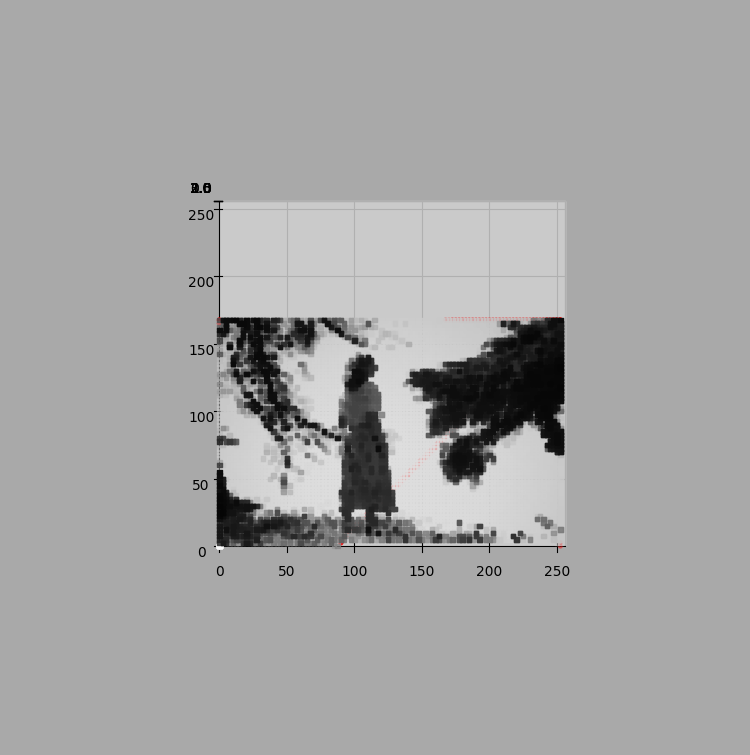

In [114]:
# 3D scatterplot of tri verts
fig = plt.figure(facecolor='darkgrey', figsize=[7.5,7.55])
ax = fig.add_subplot(projection='3d')
ax.set_facecolor('darkgrey') 

ax.view_init(elev=90, azim=-90, roll=0)
proj_types = ['ortho','persp']
ax.set_proj_type(proj_types[0])

plt.axis('scaled')

colors = 1 - (img_verts_from_tri[:,2] - min_thickness) / (max_thickness - min_thickness)
colors = np.clip(colors, 0, 1)
colors = [(x,x,x) for x in colors]

# ax.scatter(verts_base[:,0], verts_base[:,1], verts_base[:,2], marker='.', c='b')
# ax.scatter(verts[:,0], verts[:,1], verts[:,2], marker='.', c=colors)
ax.scatter(base_verts_from_tri[:,0], base_verts_from_tri[:,1], base_verts_from_tri[:,2], marker='.', c='r', s=28)
ax.scatter(img_verts_from_tri[:,0], img_verts_from_tri[:,1], img_verts_from_tri[:,2], marker='s', c=colors, s=10)


ax.set_xlim(0, max_dim)
ax.set_ylim(0, max_dim)
ax.set_zlim(0, max_thickness)
plt.show()


In [110]:
# Fan portion of side walls
# TODO:
print(nor)

[-1.  0.  0.]
